In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ast
import itertools
import os
import pandas as pd

In [2]:
def parse_log(fn):
    with open(fn, "r") as f:
        log = f.readlines()
    log = [f.rstrip() for f in log]
    mark_idx = []
    for idx, l in enumerate(log):
        if 'iter ' in l or 'stopping criterion' in l:
            mark_idx.append(idx)

    run_time = []
    for idx in mark_idx[1:]:
        run_time.append(ast.literal_eval(log[idx-1].split(" ")[-1][:-1]))

    optimal_Is = []
    optimal_quantizers = []
    optimal_dists = []
    for i, _ in enumerate(mark_idx[:-1]):
        mark_idx_input = []
        for idx, line in enumerate(log[mark_idx[i]:mark_idx[i+1]]):
            if "given input" in line:
                mark_idx_input.append(idx)
            if "optimal quantizer" in line:
                mark_idx_input.append(idx)
            if "optimal input distribution" in line:
                mark_idx_input.append(idx)
            if "optimal I" in line:
                mark_idx_input.append(idx)
        optimal_Is.append(ast.literal_eval(log[mark_idx[i]:mark_idx[i+1]][mark_idx_input[-1]].split(" ")[-1]))
        
        optimal_quantizer = "".join(log[mark_idx[i]:mark_idx[i+1]][mark_idx_input[1]:mark_idx_input[2]]).split(" [")[-1]
        optimal_quantizer = optimal_quantizer.split("]")[0].strip().split(" ")
        optimal_quantizer = filter(lambda x: x != '', optimal_quantizer)
        optimal_quantizer = np.array([ast.literal_eval(x) for x in optimal_quantizer])
        optimal_quantizers.append(optimal_quantizer)

        optimal_dist = "".join(log[mark_idx[i]:mark_idx[i+1]][mark_idx_input[2]:mark_idx_input[3]]).split(" [")[-1]
        optimal_dist = optimal_dist.split("]")[0].strip().split(" ")
        optimal_dist = filter(lambda x: x != '', optimal_dist)
        optimal_dist = np.array([ast.literal_eval(x) for x in optimal_dist])
        optimal_dists.append(optimal_dist)
    
    return len(run_time), run_time, optimal_quantizers, optimal_dists, optimal_Is

Test

In [149]:
# fn = './logs/3_levels/mode3.sigma1.seed301554.time1672258071.log'
parse_log(fn)

(2,
 [37.0786, 37.7508],
 array([-8.  , -1.36,  1.36,  8.  ]),
 array([0.38174668, 0.23650665, 0.38174667]),
 [1.1318035933560924, 1.1318035933560924])

Run

In [38]:
level = 4
root_path = "./logs/{}_levels/".format(level)
files = os.listdir(root_path)
files = [root_path + f for f in files if f.endswith(".log") and 'mode4' not in f]

In [39]:
data_parse = {}

for fn in files:
    key = fn.split("/")[-1].split(".")[-2]
    data_parse[key] = parse_log(fn)
    
df = pd.DataFrame(data_parse).T.reset_index()
df.columns = ["file", "num_iter", "run_time_iter", "opt_thres", "opt_dist", "opt_I"]
df["run_time_iter_cumsum"] = df["run_time_iter"].apply(lambda x: np.cumsum(x))
df["max_opt_I"] = df["opt_I"].apply(lambda x: np.max(x))
max_opt_I = np.max(df["max_opt_I"])
percent_max = 1 - len(df[df["max_opt_I"] < max_opt_I])/len(df)

In [42]:
df["rt"] = df["run_time_iter"].apply(lambda x: sum(x))
df["rt"].mean()

302.78537600000004

In [50]:
df[df["max_opt_I"]==df["max_opt_I"].max()][["opt_thres","opt_dist"]].iloc[11,:].opt_dist

[array([0.3574498, 0.1425502, 0.1425502, 0.3574498]),
 array([0.36164165, 0.13835742, 0.13835698, 0.36164395]),
 array([0.36164165, 0.13835742, 0.13835698, 0.36164395])]

In [35]:
# drop 1 row due to numerical blow up, level5
df = df[df["num_iter"]!=9]

In [28]:
df.to_csv("./logs_parsed/log_parsed_{}_levels.csv".format(level))

In [6]:
# df = pd.read_csv("./logs_parsed/log_parsed_{}_levels.csv".format(level))

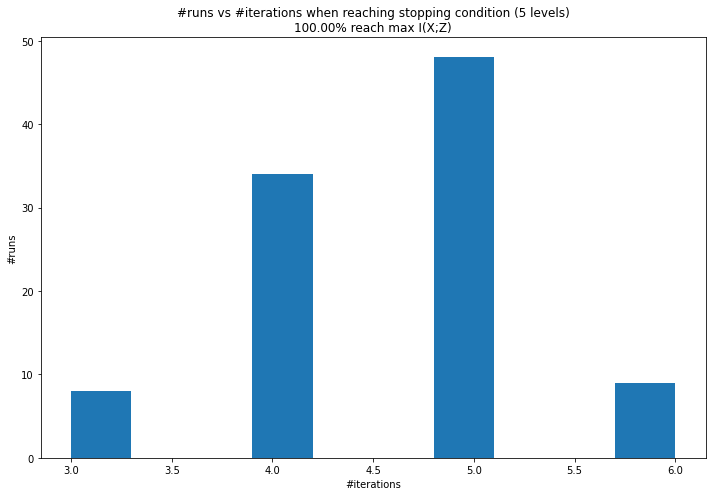

In [36]:
fig = plt.figure(figsize=(10,7))
plt.hist(df["num_iter"])
plt.ylabel("#runs")
plt.xlabel("#iterations")
plt.title("#runs vs #iterations when reaching stopping condition ({} levels)\n{:.2f}% reach max I(X;Z)".format(level, 100*percent_max))
# plt.show()
plt.tight_layout()
fig.savefig("./plots/plot_a_{}levels.png".format(level), dpi=400)

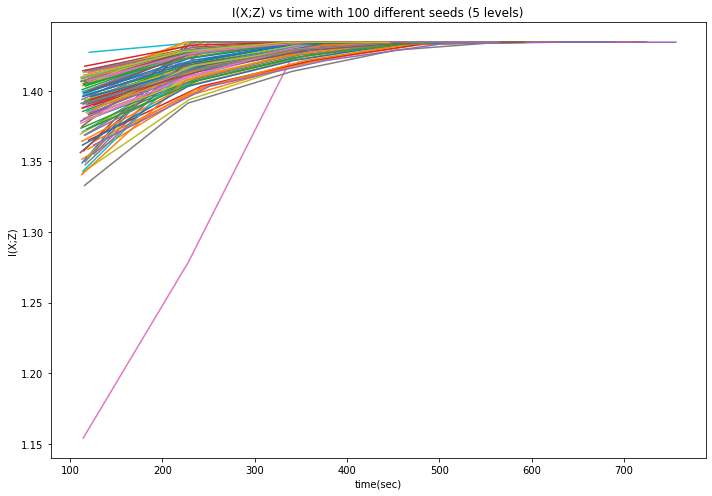

In [37]:
fig = plt.figure(figsize=(10,7))
for idx, row in df.iterrows():
    plt.plot(row["run_time_iter_cumsum"], row["opt_I"])
plt.xlabel("time(sec)")
plt.ylabel("I(X;Z)")
plt.title("I(X;Z) vs time with 100 different seeds ({} levels)".format(level))
# plt.show()
plt.tight_layout()
fig.savefig("./plots/plot_b_{}levels.png".format(level), dpi=400)